so long and thanks for all the fish

Neural Prophet
- https://github.com/ourownstory/neural_prophet

Time to Vec
- https://arxiv.org/pdf/1907.05321.pdf

Bayesian Structural time Series
- https://people.ischool.berkeley.edu/~hal/Papers/2013/pred-present-with-bsts.pdf

Data
- https://www.cs.utexas.edu/~rofuyu/papers/tr-mf-nips.pdf
- https://files.stlouisfed.org/files/htdocs/conferences/2014-nber-nsf/docs/papers/Nicholson,%20Will.pdf

Blogs
- https://medium.com/slalom-technology/failing-fast-with-deepar-neural-networks-for-time-series-ef442bf03567
- https://towardsdatascience.com/the-fall-of-rnn-lstm-2d1594c74ce0

Do deep nets need to be so deep
- https://arxiv.org/abs/1312.6184
- https://arxiv.org/abs/1312.6184

# Goals

- model should reduce to fb prophet when some input parameter is 1 (e.g. number of layers) and before any link functions are applied. In other words, fb prophet should be a special case
- demonstrate ability to support non normal distributions - count data, conversion rates
- demonstrate generalization to new "items" (IDs) via collaborative layers
- support arbitrary loss functions
- support multi-parameter distribution modeling

# TODO:

- Handle outliers using markov transition: from state outlier to state not outlier
- simulated data
- try overfitting to a single house
- try different data set: parts or https://www.kaggle.com/c/web-traffic-time-series-forecasting
- can we incorporate https://en.wikipedia.org/wiki/Discrete-time_Fourier_transform
- maybe offset the `t` in seasonal layers with the trend embedding
- Use RBF for holidays

In [1]:
import pandas as pd

df = pd.read_csv('../data/LD2011_2014.txt', sep=';', thousands=',', index_col=0)
df.index = pd.to_datetime(df.index)
df.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 00:30:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 00:45:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 01:15:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0


In [2]:
df.shape

(140256, 370)

In [3]:
df.index.rename('ds', inplace=True)

In [4]:
df.columns = [int(c.split('_')[-1]) for c in df.columns]
df = df.melt(ignore_index=False, value_vars=df.columns, var_name='id', value_name='usage')
df.head()

,id,usage
ds,,
2011-01-01 00:15:00,1,0.0
2011-01-01 00:30:00,1,0.0
2011-01-01 00:45:00,1,0.0
2011-01-01 01:00:00,1,0.0
2011-01-01 01:15:00,1,0.0


In [5]:
df.shape

(51894720, 2)

In [6]:
df = df.groupby(['id', pd.Grouper(freq='H')]).usage.sum()

In [7]:
df = df.to_frame().reset_index()
df.head()

,id,ds,usage
0,1,2011-01-01 00:00:00,0.0
1,1,2011-01-01 01:00:00,0.0
2,1,2011-01-01 02:00:00,0.0
3,1,2011-01-01 03:00:00,0.0
4,1,2011-01-01 04:00:00,0.0


In [8]:
df.shape

(12974050, 3)

In [9]:
T0 = pd.Timestamp(0)
df['t'] = (df.ds - T0).dt.total_seconds() / (60 * 60 * 24)

In [10]:
beginnings = df[df.usage.gt(0)].reset_index().groupby('id').ds.min()
beginnings

id
1     2012-01-01
2     2012-01-01
3     2012-01-01
4     2012-01-01
5     2012-01-01
         ...    
366   2012-01-01
367   2012-01-01
368   2012-01-01
369   2012-01-01
370   2013-01-01
Name: ds, Length: 370, dtype: datetime64[ns]

In [11]:
df = df[df.ds > df.id.map(beginnings)]
df.shape

(10484118, 4)

In [12]:
C = 1e9
df['usage'] /= C

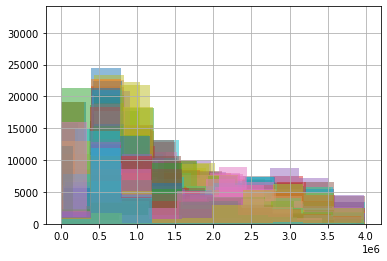

In [13]:
_ = df.groupby('id').usage.hist(alpha=.5)

In [14]:
# %%time

# df.sort_values(['id', 'ds'], inplace=True)
# df['scaling_factor'] = (1 / C) + df.set_index('ds').groupby('id').usage.rolling('60D', closed='right', engine='numba', raw=True).mean().values
# df.head()

In [15]:
df.shape

(10484118, 4)

In [16]:
# import matplotlib.pyplot as plt


# fig, ax = plt.subplots(figsize=(10, 5))

# df = pd.concat(
#     d.iloc[60 * 24 * 4:]
#     for _, d in df.groupby('id')
# )
# df.iloc[:60 * 24 * 4:].set_index('ds').usage.plot()
# df.iloc[:60 * 24 * 4].set_index('ds').scaling_factor.plot()

<AxesSubplot:xlabel='ds'>

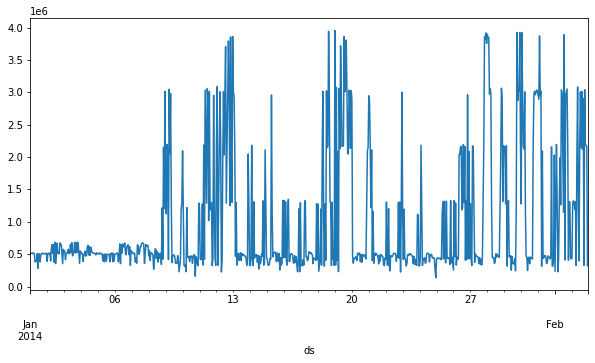

In [17]:
X = (
    df[df.id.eq(df.id.sample().iloc[0])]
    .sort_values('ds')
    .set_index('ds')
    .usage
    .loc['2014-01-01':'2014-02-02']
)
X.plot(figsize=(10, 5))

In [18]:
# (df.usage - df.scaling_factor).hist()

In [19]:
df.head()

,id,ds,usage,t
8761,1,2012-01-01 01:00:00,1.192893e+06,15340.041667
8762,1,2012-01-01 02:00:00,1.446701e+06,15340.083333
8763,1,2012-01-01 03:00:00,8.629442e+05,15340.125000
8764,1,2012-01-01 04:00:00,5.329949e+05,15340.166667
8765,1,2012-01-01 05:00:00,8.629442e+05,15340.208333


In [20]:
df_train = df[df.ds.lt('2014-07-01')]
df_test = df[df.ds.between('2014-07-01', '2014-07-30')]
df_train.shape, df_test.shape

((8850237, 4), (257481, 4))

In [21]:
id_map = {old: new for new, old in enumerate(df_train.id.unique())}
df_train['id'] = df_train.id.map(id_map)
df_test['id'] = df_test.id.map(id_map)
df_test = df_test[df_test.id.notnull()]

/var/folders/3_/t5j_szld1slc2jm0vb2r4s180000gn/T/ipykernel_18052/2482032622.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['id'] = df_train.id.map(id_map)
/var/folders/3_/t5j_szld1slc2jm0vb2r4s180000gn/T/ipykernel_18052/2482032622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['id'] = df_test.id.map(id_map)


In [22]:
df_train.shape, df_test.shape

((8850237, 4), (257193, 4))

# Model

In [24]:
from tensorflow import keras

import sys; sys.path.append('..')
from ryan_adams import *

n_items = df_train.id.nunique()
t_range = df_train.t.min(), df_train.t.max()
model = RyanAdams(
    trends=[
        LinearTrend(n_items=1, t_range=t_range, name='global_trend'),
        LinearTrend(n_items=n_items, t_range=t_range, name='local_trend'),
    ],
    seasonalities=[
        Seasonality(n_items=1, period=365.25, order=10, name='gobal_seasonality_yearly'),
        Seasonality(n_items=1, period=7, order=3, name='gobal_seasonality_weekly'),
        Seasonality(n_items=1, period=1, order=10, name='gobal_seasonality_daily'),
        Seasonality(n_items=n_items, period=365.25, order=10, name='local_seasonality_yearly'),
        Seasonality(n_items=n_items, period=7, order=3, name='local_seasonality_weekly'),
        Seasonality(n_items=n_items, period=1, order=10, name='local_seasonality_daily'),
    ],
    outer_layers=[
        keras.layers.Dense(10, activation='linear'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(10, activation='linear'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(10, activation='linear'),
    ],
    output_activations='softplus',
)

2022-08-03 13:31:09.056302: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
model._model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 t (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 id (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 global_trend (LinearTrend)     (None, 1)            22          ['t[0][0]']                      
                                                                                                  
 local_trend (LinearTrend)      (None, 1)            8118        ['t[0][0]',                      
                                                                  'id[0][0]']                 

In [26]:
import tensorflow as tf

train_sample = df_train

Xt_train = train_sample[['id', 't']].to_dict('series')
Xt_test = df_test[['id', 't']].to_dict('series')

model._model.fit(
    Xt_train,
    train_sample.usage,
    batch_size=32,
    epochs=20,
    validation_data=(Xt_test, df_test.usage),
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(verbose=1, patience=3)]
)

Epoch 1/20
 46224/276570 [====>.........................] - ETA: 7:47 - loss: 934669189120.0000

KeyboardInterrupt: 

<AxesSubplot:>

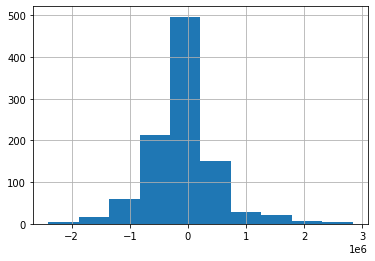

In [27]:
zz = df_train.sample(1000)
y_test_params = model._model.predict(zz[['id', 't']].to_dict('series'))
mu = y_test_params[:, 0]

(zz.usage - mu).hist()

In [ ]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 5), sharey=True)

i = np.random.choice(df_train.id)
zz = df_train[df_train.id == i].set_index('ds').sort_index()
zz = zz.loc[:zz.index.min() + pd.to_timedelta('7D')]
zz['p'] = model._model.predict(zz[['id', 't']].to_dict('series'))[:, 0]
zz.usage.plot(ax=ax, color='C0')
zz.p.plot(ax=ax, color='C1')

In [30]:
# plot_model_components(model)